<a href="https://colab.research.google.com/github/hiram-avila/Credit-Default-Prediction/blob/main/notebooks/modelos_credito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# --- IMPORTAR LIBRERÍAS ---
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# --- CONFIGURACIÓN ---
np.random.seed(42)
n = 100_000  # 100k clientes

# --- DATOS SIMULADOS (distribuciones REALES) ---
data = {
    'edad': np.random.beta(2, 3, n) * 52 + 18,
    'ingresos_mensuales': np.random.lognormal(8.5, 0.6, n),
    'score_bureau': np.random.beta(2, 5, n) * 550 + 300,
    'atrasos_ult_6m': np.random.negative_binomial(1, 0.9, n),
    'meses_con_cuenta': np.random.gamma(3, 8, n),
    'uso_tarjeta_%': np.random.beta(2, 3, n) * 100,
    'monto_solicitado': np.random.lognormal(8, 0.8, n),
    'default_12m': np.random.binomial(1, 0.08, n)  # 8% impago
}

df = pd.DataFrame(data)
print(df.head())

        edad  ingresos_mensuales  score_bureau  atrasos_ult_6m  \
0  43.712575         2128.242684    476.504828               0   
1  37.507944         3630.948664    504.667376               0   
2  45.550200         4367.748691    444.650910               0   
3  30.290504         6586.016133    399.408862               0   
4  57.939005         2397.109673    410.224168               0   

   meses_con_cuenta  uso_tarjeta_%  monto_solicitado  default_12m  
0         11.019281      40.581571       8432.208820            0  
1         17.219861      41.066513       9190.432489            0  
2         26.930572      40.408811        683.630986            0  
3         15.576923      21.252827      10377.872359            0  
4          5.230110      53.953024       4672.490915            0  


In [48]:
df['ratio_deuda_ingreso'] = df['monto_solicitado'] / df['ingresos_mensuales']

In [49]:
df = df.sort_values('meses_con_cuenta')
train = df.iloc[:70_000]
test = df.iloc[85_000:]  # 15k clientes

X_train = train.drop('default_12m', axis=1)
y_train = train['default_12m']
X_test = test.drop('default_12m', axis=1)
y_test = test['default_12m']

In [50]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=500,
    class_weight='balanced_subsample',
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', min_samples_leaf=10,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [51]:
# --- CORREGIR PARTE 6: RESULTADOS ---
from sklearn.metrics import classification_report, roc_auc_score

# Asegurar que X_test tenga la feature 'ratio_deuda_ingreso'
if 'ratio_deuda_ingreso' not in X_test.columns:
    X_test['ratio_deuda_ingreso'] = df.loc[X_test.index, 'monto_solicitado'] / df.loc[X_test.index, 'ingresos_mensuales']

# Predecir
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Resultados
print("AUC:", round(roc_auc_score(y_test, y_proba), 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

AUC: 0.512

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     13807
           1       0.00      0.00      0.00      1193

    accuracy                           0.92     15000
   macro avg       0.46      0.50      0.48     15000
weighted avg       0.85      0.92      0.88     15000



In [54]:
# --- CORREGIR TODO: DATOS + DIVISIÓN + FEATURE + MODELO ---
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# 1. DATOS (10k para rapidez)
np.random.seed(42)
n = 10_000
data = {
    'edad': np.random.beta(2, 3, n) * 52 + 18,
    'ingresos_mensuales': np.random.lognormal(8.5, 0.6, n),
    'score_bureau': np.random.beta(2, 5, n) * 550 + 300,
    'atrasos_ult_6m': np.random.negative_binomial(1, 0.9, n),
    'meses_con_cuenta': np.random.gamma(3, 8, n),
    'monto_solicitado': np.random.lognormal(8, 0.8, n),
    'default_12m': np.random.binomial(1, 0.08, n)
}
df = pd.DataFrame(data)

# 2. FEATURE
df['ratio_deuda_ingreso'] = df['monto_solicitado'] / df['ingresos_mensuales']

# 3. DIVISIÓN CORRECTA
df = df.sort_values('meses_con_cuenta')
train = df.iloc[:7000]
test = df.iloc[7000:]  # 1500 clientes

X_train = train.drop('default_12m', axis=1)
y_train = train['default_12m']
X_test = test.drop('default_12m', axis=1)
y_test = test['default_12m']

# 4. MODELO
rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 5. RESULTADOS
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("AUC:", round(roc_auc_score(y_test, y_proba), 3))
print(classification_report(y_test, y_pred))

AUC: 0.508
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      2730
           1       0.00      0.00      0.00       270

    accuracy                           0.91      3000
   macro avg       0.45      0.50      0.48      3000
weighted avg       0.83      0.91      0.87      3000



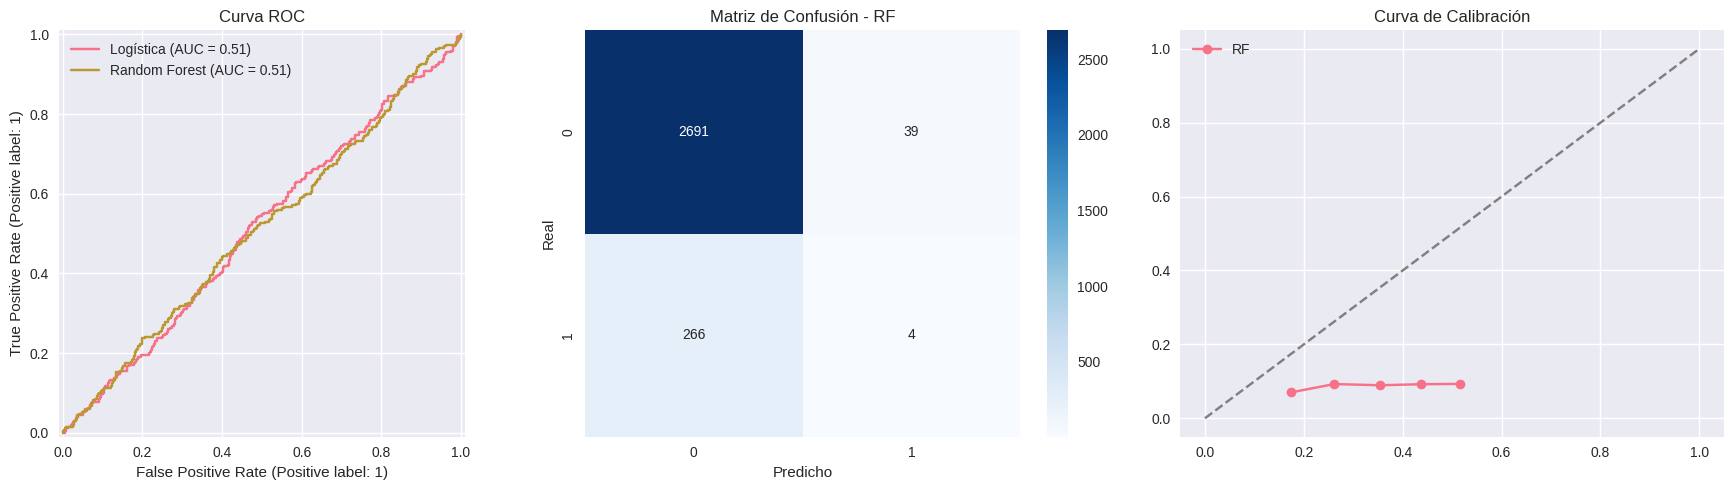

In [55]:
# --- ENTRENAR MODELOS ANTES DE DEFINIR `models` ---
from sklearn.linear_model import LogisticRegression

# Logística
log = LogisticRegression(class_weight='balanced', max_iter=1000)
log.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced_subsample',
    max_depth=12,
    min_samples_leaf=10,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# --- AHORA DEFINIR `models` ---
models = {'Logística': log, 'Random Forest': rf}

# --- GRÁFICAS ---
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# ROC
for name, model in models.items():
    RocCurveDisplay.from_predictions(y_test, model.predict_proba(X_test)[:, 1], name=name, ax=ax[0])
ax[0].set_title("Curva ROC")
ax[0].legend()

# Matriz de confusión
sns.heatmap(confusion_matrix(y_test, rf.predict(X_test)), annot=True, fmt='d', ax=ax[1], cmap='Blues')
ax[1].set_title("Matriz de Confusión - RF")
ax[1].set_xlabel("Predicho")
ax[1].set_ylabel("Real")

# Calibración
prob_true, prob_pred = calibration_curve(y_test, rf.predict_proba(X_test)[:, 1], n_bins=10)
ax[2].plot(prob_pred, prob_true, marker='o', label='RF')
ax[2].plot([0,1], [0,1], '--', color='gray')
ax[2].set_title("Curva de Calibración")
ax[2].legend()

plt.tight_layout()
plt.show()

Umbral óptimo (validación): Logistic 0.41, RandomForest 0.26
Logistic metrics: {'accuracy': 0.5589333333333333, 'precision': 0.4432902863559798, 'recall': 0.8765729089563287, 'f1': 0.5888129272840273, 'auc': np.float64(0.6828458934129044)}
RandomForest metrics: {'accuracy': 0.5196666666666667, 'precision': 0.4267945695471913, 'recall': 0.9715025906735751, 'f1': 0.5930528099406948, 'auc': np.float64(0.7096455885116207)}


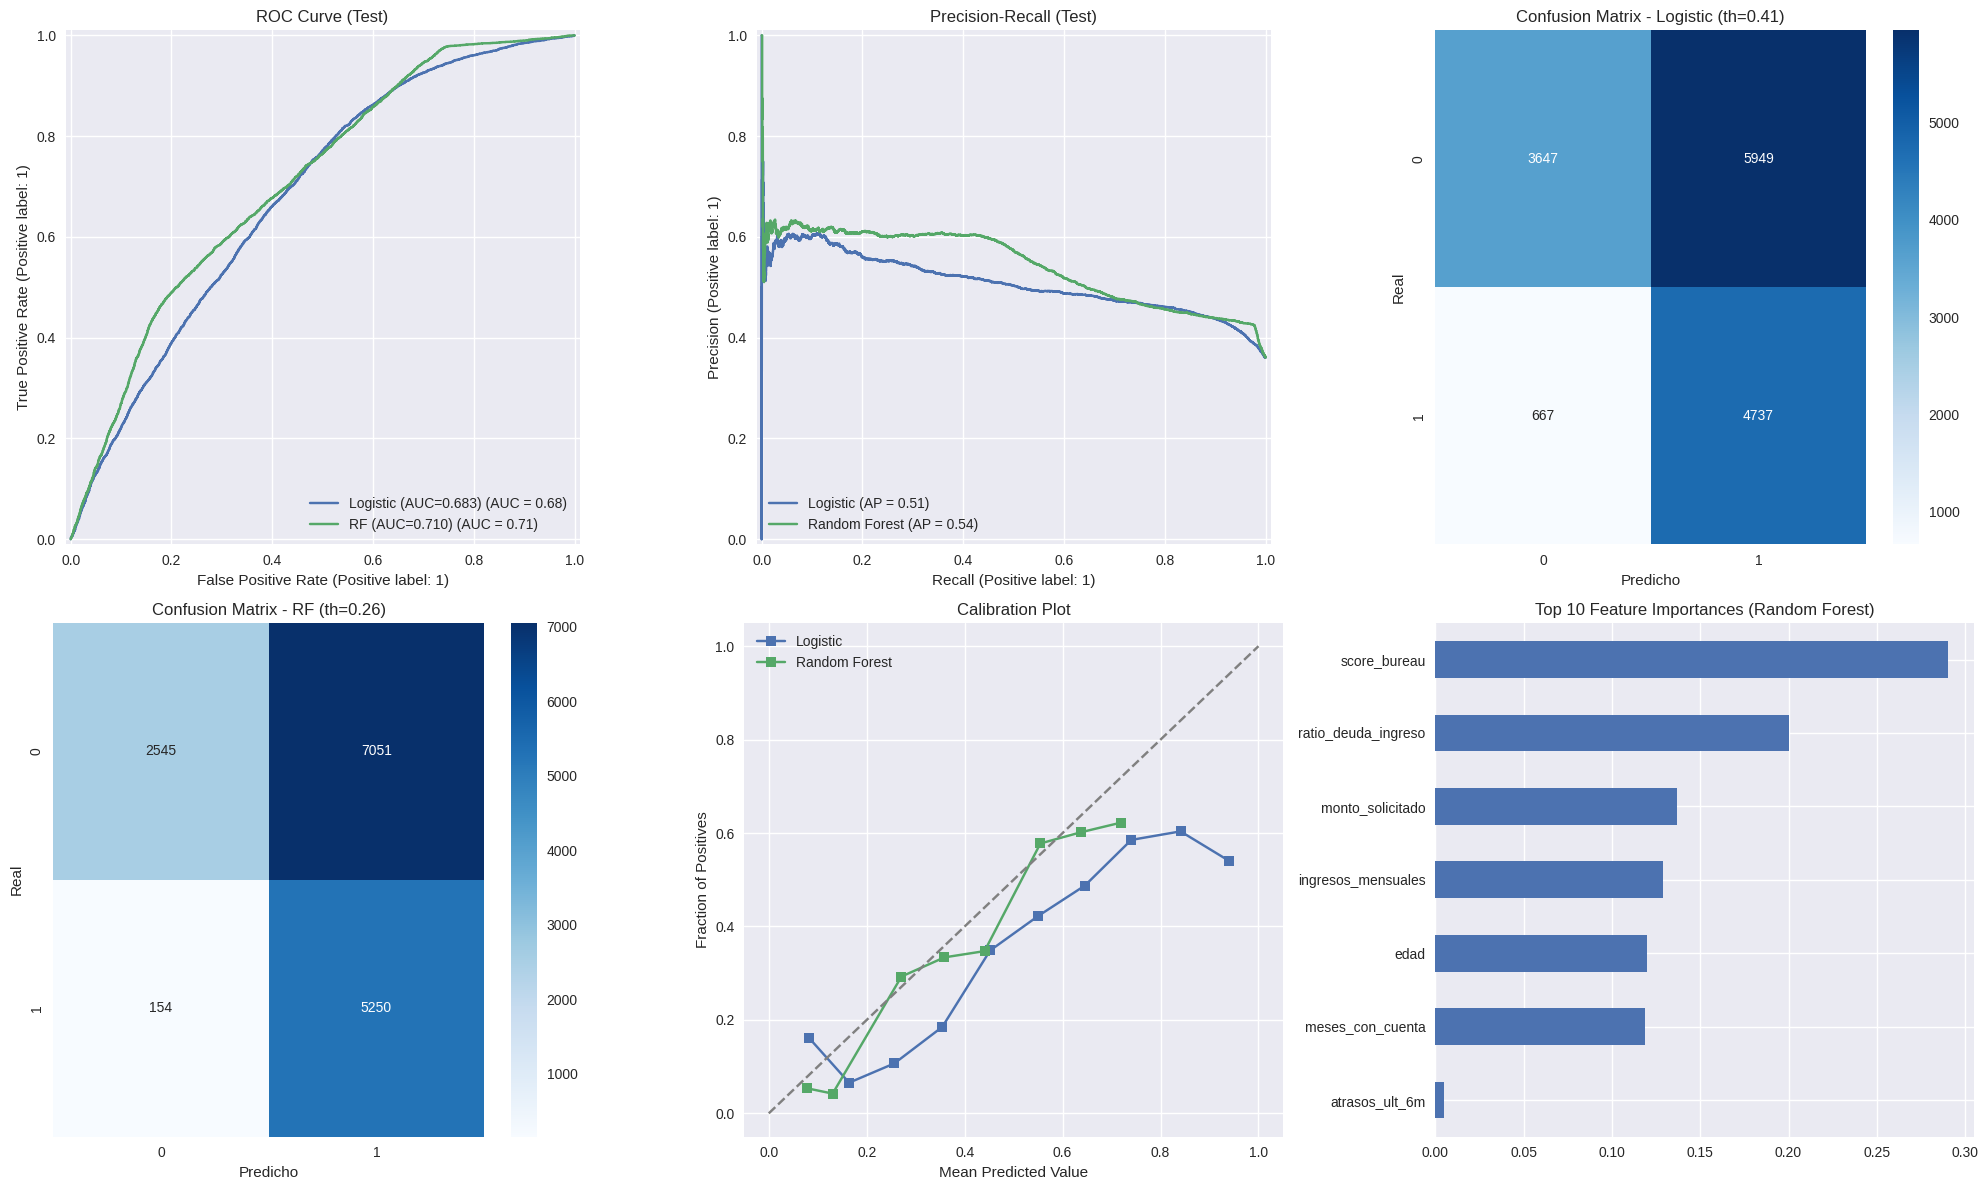

In [68]:
# --- CÓDIGO FINAL CORREGIDO Y MEJORADO ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")
# %matplotlib inline  # descomenta si estás en Jupyter

RND = 42
np.random.seed(RND)

# 1) DATOS SIMULADOS (100k clientes)
n = 100_000
data = {
    # edades entre 18 y ~70 (beta para dar sesgo hacia adultos jóvenes)
    "edad": np.random.beta(2, 3, n) * 52 + 18,
    # ingresos mensuales (lognormal): parámetros realistas si se normaliza luego
    "ingresos_mensuales": np.random.lognormal(8.5, 0.6, n),
    "score_bureau": np.random.beta(2, 5, n) * 550 + 300,
    "atrasos_ult_6m": np.random.negative_binomial(1, 0.9, n),
    # "meses_con_cuenta" lo usamos para un split temporal sintético
    "meses_con_cuenta": np.random.gamma(3, 8, n),
    "monto_solicitado": np.random.lognormal(8, 0.8, n)
}

# Crear DataFrame
df = pd.DataFrame(data)
df["ratio_deuda_ingreso"] = df["monto_solicitado"] / df["ingresos_mensuales"]

# --- Generar variable de default realista ---
p = (
    0.05
    + 0.3 * (df["score_bureau"] < 500)
    + 0.25 * (df["ratio_deuda_ingreso"] > 0.8)
    + 0.2 * (df["atrasos_ult_6m"] > 2)
)
p = np.clip(p, 0, 1)
df["default_12m"] = np.random.binomial(1, p)


# Feature engineering simple
df["ratio_deuda_ingreso"] = df["monto_solicitado"] / (df["ingresos_mensuales"] + 1e-9)
df["ingresos_mensuales"] = df["ingresos_mensuales"].clip(lower=100)  # evita ceros/valores pequeños

# 2) DIVISIÓN TEMPORAL SINTÉTICA
# Ordenamos por 'meses_con_cuenta' para simular que los registros antiguos tienen menor 'meses_con_cuenta'
df = df.sort_values("meses_con_cuenta").reset_index(drop=True)

# Train / Validation / Test split (70/15/15) - usamos validación para ajustar umbral
n_train = int(len(df) * 0.70)   # 70k
n_val = int(len(df) * 0.15)     # 15k
train = df.iloc[:n_train]
val = df.iloc[n_train:n_train + n_val]
test = df.iloc[n_train + n_val:]

X_train = train.drop("default_12m", axis=1)
y_train = train["default_12m"]
X_val = val.drop("default_12m", axis=1)
y_val = val["default_12m"]
X_test = test.drop("default_12m", axis=1)
y_test = test["default_12m"]

# 3) MODELOS
# Regresión logística con pipeline (requiere escalado por los valores grandes de ingresos/monto)
log_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("log", LogisticRegression(class_weight="balanced", max_iter=1000, random_state=RND))
])
log_pipe.fit(X_train, y_train)

# Random Forest (no necesita escalado, pero lo incluimos en pipeline si queremos consistencia)
rf = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced_subsample",
    min_samples_leaf=5,
    random_state=RND,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# 4) PREDICCIONES (probabilidades)
proba_log_val = log_pipe.predict_proba(X_val)[:, 1]
proba_rf_val = rf.predict_proba(X_val)[:, 1]

proba_log_test = log_pipe.predict_proba(X_test)[:, 1]
proba_rf_test = rf.predict_proba(X_test)[:, 1]

# 5) AJUSTE DE UMBRAL (threshold tuning) en el set de VALIDACIÓN
# Elegimos el umbral que maximiza F1 en validación para cada modelo (ejemplo práctico)
from sklearn.metrics import f1_score

def best_threshold(y_true, y_proba, metric=f1_score, thresholds=np.linspace(0.01, 0.99, 99)):
    best_t, best_m = 0.5, -1
    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        m = metric(y_true, y_pred)
        if m > best_m:
            best_m = m
            best_t = t
    return best_t, best_m

th_log, f1_log = best_threshold(y_val, proba_log_val)
th_rf, f1_rf = best_threshold(y_val, proba_rf_val)

# Aplicar umbral en test
y_pred_log_test = (proba_log_test >= th_log).astype(int)
y_pred_rf_test = (proba_rf_test >= th_rf).astype(int)

# 6) MÉTRICAS en TEST
def metrics_report(y_true, y_pred, y_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "auc": roc_auc_score(y_true, y_proba)
    }

metrics_log = metrics_report(y_test, y_pred_log_test, proba_log_test)
metrics_rf = metrics_report(y_test, y_pred_rf_test, proba_rf_test)

print("Umbral óptimo (validación): Logistic {:.2f}, RandomForest {:.2f}".format(th_log, th_rf))
print("Logistic metrics:", metrics_log)
print("RandomForest metrics:", metrics_rf)

# 7) GRÁFICAS COMPARATIVAS: ROC, Precision-Recall, Confusion Matrix, Calibración
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
axs = axs.ravel()

# ROC
RocCurveDisplay.from_predictions(y_test, proba_log_test, name=f"Logistic (AUC={metrics_log['auc']:.3f})", ax=axs[0])
RocCurveDisplay.from_predictions(y_test, proba_rf_test, name=f"RF (AUC={metrics_rf['auc']:.3f})", ax=axs[0])
axs[0].set_title("ROC Curve (Test)")

# Precision-Recall
PrecisionRecallDisplay.from_predictions(y_test, proba_log_test, name="Logistic", ax=axs[1])
PrecisionRecallDisplay.from_predictions(y_test, proba_rf_test, name="Random Forest", ax=axs[1])
axs[1].set_title("Precision-Recall (Test)")

# Confusion matrices (usando umbrales optimizados)
cm_rf = confusion_matrix(y_test, y_pred_rf_test)
cm_log = confusion_matrix(y_test, y_pred_log_test)
sns.heatmap(cm_log, annot=True, fmt="d", ax=axs[2], cmap="Blues")
axs[2].set_title(f"Confusion Matrix - Logistic (th={th_log:.2f})")
axs[2].set_xlabel("Predicho"); axs[2].set_ylabel("Real")

sns.heatmap(cm_rf, annot=True, fmt="d", ax=axs[3], cmap="Blues")
axs[3].set_title(f"Confusion Matrix - RF (th={th_rf:.2f})")
axs[3].set_xlabel("Predicho"); axs[3].set_ylabel("Real")

# Calibration plots: mean_predicted_value (x) vs fraction_of_positives (y)
frac_pos_log, mean_pred_log = calibration_curve(y_test, proba_log_test, n_bins=10, strategy="uniform")
frac_pos_rf, mean_pred_rf = calibration_curve(y_test, proba_rf_test, n_bins=10, strategy="uniform")
axs[4].plot(mean_pred_log, frac_pos_log, "s-", label=f"Logistic")
axs[4].plot(mean_pred_rf, frac_pos_rf, "s-", label=f"Random Forest")
axs[4].plot([0, 1], [0, 1], "--", color="gray")
axs[4].set_title("Calibration Plot")
axs[4].set_xlabel("Mean Predicted Value")
axs[4].set_ylabel("Fraction of Positives")
axs[4].legend()

# Feature importances (top 10) para RF
feat_names = X_train.columns
importances = rf.feature_importances_
imp_df = pd.Series(importances, index=feat_names).sort_values(ascending=True).tail(10)
imp_df.plot.barh(ax=axs[5])
axs[5].set_title("Top 10 Feature Importances (Random Forest)")

plt.tight_layout()
plt.show()